## kmeans 알고리즘으로 결측값 대체하기 
$\Rightarrow$ 시도했는데 아직 성공못함

* kmeans를 사용하려면 k값(클러스터)값을 알아야 함.
* 최적의 클러스터 값을 찾기 위해 이니셔와 실루엣점수 지표를 사용함.
* k = 5가 최적으로 보임

In [196]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from copy import deepcopy
import random

# 데이터 가져오기

In [3]:
train_df=pd.read_csv('./data/train.csv')
test_df=pd.read_csv('./data/test.csv')
train_df_backup = deepcopy(train_df)
test_df_backup = deepcopy(test_df)

## 데이터 분석

In [4]:
train_df = deepcopy(train_df_backup)

In [6]:
train_df.isnull().sum()

date               0
precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10              67
PM2.5             68
humidity           0
sunshine_sum       5
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
dtype: int64

In [21]:
train_df.T.isnull().sum()

0       1
1       1
2       1
3       1
4       1
       ..
1090    0
1091    0
1092    0
1093    1
1094    0
Length: 1095, dtype: int64

In [37]:
for i in range(5):
    print(f'결측값 개수가 {i}개인 데이터 수 {len(train_df.T.isnull().sum()[train_df.T.isnull().sum()==i])}')

결측값 개수가 0개인 데이터 수 386
결측값 개수가 1개인 데이터 수 638
결측값 개수가 2개인 데이터 수 33
결측값 개수가 3개인 데이터 수 38
결측값 개수가 4개인 데이터 수 0


In [95]:
train_df.columns

'precipitation'

In [101]:
nanlist=list()
for row_i, row in enumerate(train_df.to_numpy()):
    for i, v in enumerate(row):
        if v!=v:
            nanlist.append([str(row_i),train_df.columns[i]])

In [103]:
nandict= dict()
for i,j in nanlist:
    if not i in nandict.keys():
        nandict[i]=[j]
    else:
        nandict[i].append(j)

In [104]:
nandict

{'0': ['precipitation'],
 '1': ['precipitation'],
 '2': ['precipitation'],
 '3': ['precipitation'],
 '4': ['precipitation'],
 '5': ['precipitation'],
 '6': ['precipitation'],
 '10': ['precipitation'],
 '13': ['precipitation'],
 '16': ['precipitation'],
 '17': ['sunshine_sum'],
 '18': ['precipitation'],
 '19': ['precipitation'],
 '20': ['precipitation'],
 '22': ['precipitation'],
 '23': ['precipitation'],
 '24': ['precipitation'],
 '25': ['precipitation', 'sunshine_sum'],
 '26': ['precipitation'],
 '27': ['precipitation'],
 '28': ['precipitation'],
 '31': ['precipitation'],
 '32': ['precipitation'],
 '34': ['precipitation'],
 '35': ['precipitation'],
 '36': ['precipitation'],
 '37': ['precipitation'],
 '38': ['precipitation'],
 '39': ['precipitation'],
 '40': ['precipitation'],
 '43': ['precipitation'],
 '44': ['precipitation'],
 '45': ['precipitation', 'sunshine_sum'],
 '46': ['precipitation'],
 '47': ['precipitation', 'PM10', 'PM2.5'],
 '48': ['precipitation'],
 '49': ['precipitation'

# 데이터 전처리

## 결측치 1개 처리하기

### 기준 데이터 만들기

In [111]:
std_df=train_df_backup[train_df_backup.T.isnull().sum()==0].iloc[:,1:]

### 클러스터 개수 정하기

In [182]:
print(*sorted(list(std_df['precipitation'])))

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.1 1.1 1.1 1.2 1.2 1.2 1.3 1.3 1.3 1.3 1.3 1.4 1.4 1.5 1.5 1.5 1.6 1.7 1.7 1.7 1.7 1.7 1.7 1.8 1.8 1.8 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.1 2.1 2.2 2.2 2.2 2.3 2.4 2.5 2.5 2.5 2.9 2.9 2.9 2.9 2.9 2.9 3.0 3.0 3.0 3.0 3.3 3.3 3.3 3.4 3.5 3.5 3.6 3.7 3.8 3.9 3.9 3.9 

In [181]:
print(*sorted(list(std_df['sunshine_sum'])))

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.8 0.8 0.8 0.8 0.9 0.9 1.0 1.0 1.0 1.0 1.0 1.0 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.2 1.3 1.3 1.3 1.4 1.4 1.5 1.5 1.6 1.6 1.6 1.6 1.6 1.7 1.7 1.7 1.7 1.8 1.8 1.8 1.8 1.9 1.9 1.9 1.9 1.9 1.9 2.0 2.0 2.0 2.0 2.1 2.1 2.2 2.2 2.3 2.3 2.4 2.4 2.4 2.4 2.6 2.6 2.8 2.8 2.8 2.9 3.0 3.0 3.0 3.0 3.0 3.1 3.1 3.1 3.1 3.1 3.2 3.2 3.2 3.2 3.2 3.2 3.3 3.4 3.4 3.4 3.4 3.7 3.9 3.9 3.9 4.0 4.0 4.0 4.1 4.1 4.1 4.2 4.2 4.3 4.3 4.3 4.5 4.5 4.7 4.7 4.7 4.8 4.8 4.8 4.8 4.8 4.9 4.9 4.9 5.0 5.0 5.0 5.0 

In [183]:
print(*sorted(list(std_df['PM2.5'])))

2.0 3.0 3.0 3.0 3.0 3.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 6.0 7.0 7.0 7.0 7.0 7.0 7.0 7.0 7.0 7.0 7.0 7.0 7.0 8.0 8.0 8.0 8.0 8.0 8.0 8.0 8.0 8.0 8.0 8.0 8.0 8.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 12.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 13.0 14.0 14.0 14.0 14.0 14.0 14.0 14.0 14.0 14.0 14.0 14.0 14.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 17.0 18.0 18.0 18.0 18.0 18.0 18.0 18.0 18.0 18.0 18.0 18.0 18.0 18.0 1

0 precipitation


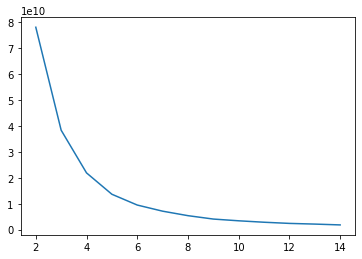

17 sunshine_sum


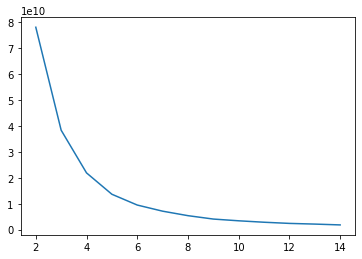

573 PM2.5


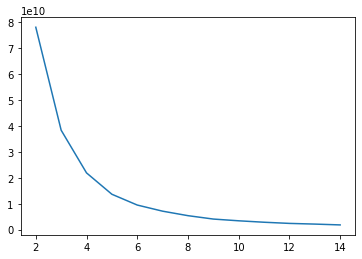

In [180]:
result=[]
for key, value in nandict.items():
    if len(value)>1:
        continue
    nan_col = nandict[key][0]
    if nan_col in result:
        continue
    result.append(nan_col)
    X=std_df.drop([nan_col],axis=1)
    print(key, nan_col)
    kmeans_list = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(2,15)]
    inertias = [kmeans_model.inertia_ for kmeans_model in kmeans_list] 
    plt.plot(range(2,15),inertias)
    plt.show()

In [168]:
result=[]
for key, value in nandict.items():
    if len(value)>1:
        continue
    nan_col = nandict[key][0]
    if nan_col in result:
        continue
    result.append(nan_col)
    X=std_df.drop([nan_col],axis=1)
    print(key, nan_col)
    for k in range(2,30):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        print(f'k : {k} 실루엣점수 : {silhouette_score(X, kmeans.labels_)}')
    print()

0 precipitation
k : 2 실루엣점수 : 0.6493964625151843
k : 3 실루엣점수 : 0.570829833338015
k : 4 실루엣점수 : 0.5607241887561686
k : 5 실루엣점수 : 0.5706845119266027
k : 6 실루엣점수 : 0.5577059798314385
k : 7 실루엣점수 : 0.5570484318494974
k : 8 실루엣점수 : 0.5568868452579878
k : 9 실루엣점수 : 0.5615458882798819
k : 10 실루엣점수 : 0.5559369809353376
k : 11 실루엣점수 : 0.5551360824539214
k : 12 실루엣점수 : 0.5520531032664059
k : 13 실루엣점수 : 0.5477688120774208
k : 14 실루엣점수 : 0.5519695743946044
k : 15 실루엣점수 : 0.550686367821247
k : 16 실루엣점수 : 0.5365411819394776
k : 17 실루엣점수 : 0.5412572957557609
k : 18 실루엣점수 : 0.547885016462236
k : 19 실루엣점수 : 0.5507956758375805
k : 20 실루엣점수 : 0.5452159613801947
k : 21 실루엣점수 : 0.5397184172895391
k : 22 실루엣점수 : 0.5465719691699222
k : 23 실루엣점수 : 0.5385015967300206
k : 24 실루엣점수 : 0.550765639619126
k : 25 실루엣점수 : 0.5381040081247324
k : 26 실루엣점수 : 0.5387570235351513
k : 27 실루엣점수 : 0.5561483471333938
k : 28 실루엣점수 : 0.5500428485886488
k : 29 실루엣점수 : 0.5579792660820817

17 sunshine_sum
k : 2 실루엣점수 : 0.64939483568

In [161]:
result=[]
for key, value in nandict.items():
    if len(value)>1:
        continue
    nan_col = nandict[key][0]
    if nan_col in result:
        continue
    result.append(nan_col)
    X=std_df.drop([nan_col],axis=1)
    print(key, nan_col, result)
    for k in range(2,15):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        y_pred = kmeans.labels_
        print(f'k : {k}')
        for label in range(0, k):
            print(round(std_df.iloc[np.where(y_pred==label)][nan_col].mean(),2), end=' ')
        print()
#         print(f'실루엣점수 : {silhouette_score(X, kmeans.labels_)}')
    print()

0 precipitation ['precipitation']
k : 2
12.12 4.65 
k : 3
14.49 2.48 8.52 
k : 4
9.04 1.24 16.49 7.31 
k : 5
7.62 17.15 0.41 3.98 9.7 
k : 6
10.39 3.39 18.71 8.99 0.42 8.35 
k : 7
10.43 1.72 8.45 18.71 4.72 0.51 8.66 
k : 8
9.72 19.59 0.51 9.02 1.8 4.38 11.47 5.06 
k : 9
9.78 0.49 4.34 21.16 8.14 1.77 9.87 13.54 6.42 
k : 10
13.54 0.76 8.14 6.29 21.16 0.49 9.78 9.87 6.69 2.38 
k : 11
10.47 0.94 11.86 21.16 6.3 0.35 5.39 13.54 4.11 9.57 2.27 
k : 12
10.55 2.66 11.86 22.42 0.35 5.39 4.11 15.58 10.01 10.71 6.3 0.46 
k : 13
22.9 4.74 8.91 0.35 2.9 11.1 10.34 4.7 10.76 6.23 0.46 7.59 15.65 
k : 14
10.34 4.7 0.44 22.9 13.6 5.85 10.76 0.89 9.63 15.65 0.61 4.74 2.47 5.01 

17 sunshine_sum ['precipitation', 'sunshine_sum']
k : 2
3.21 4.52 
k : 3
2.62 4.82 4.1 
k : 4
3.66 4.87 2.56 4.24 
k : 5
3.94 2.43 5.66 4.21 3.64 
k : 6
3.07 4.41 2.12 3.73 5.7 4.26 
k : 7
3.11 3.95 3.9 2.12 4.73 6.38 4.19 
k : 8
3.81 2.05 6.38 3.76 4.03 4.58 3.04 4.68 
k : 9
4.25 6.44 4.68 2.12 4.02 4.15 2.95 2.72 3.71 
k :

### kmeans 분석

In [ ]:
models=[]
X_dfs=[]
for key, value in nandict.items():
    if len(value)>1:
        continue
    nan_col = nandict[key][0]
    if nan_col in result:
        continue
    result.append(nan_col)
    X=std_df.drop([nan_col],axis=1)
    print(key, nan_col, result)
    for k in range(2,15):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        y_pred = kmeans.labels_
        print(f'k : {k}')
        for label in range(0, k):
            print(round(std_df.iloc[np.where(y_pred==label)][nan_col].mean(),2), end=' ')
        print()
#         print(f'실루엣점수 : {silhouette_score(X, kmeans.labels_)}')
    print()

In [197]:
X=std_df.drop([nan_col],axis=1)
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
y_pred = kmeans.labels_

In [137]:
X

,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
7,1.3,4.0,-1.2,49.0,37.0,51.9,0.5,5.2,1.8,7.1,6309
8,-4.2,-1.2,-6.1,37.0,19.0,59.4,8.4,86.6,2.9,6.1,5988
9,-7.5,-4.8,-10.3,27.0,13.0,52.0,8.8,89.8,3.0,6.1,4476
11,-10.2,-5.4,-15.3,21.0,14.0,35.4,8.8,89.8,1.7,3.6,4401
12,-4.4,-1.2,-6.6,48.0,37.0,67.3,0.9,9.2,0.8,1.7,3756
...,...,...,...,...,...,...,...,...,...,...,...
1086,4.5,8.5,-0.4,72.0,51.0,76.6,1.7,17.7,2.3,5.1,42218
1090,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103
1091,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912
1092,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747


In [150]:
std_df.iloc[np.where(y_pred==1)]['precipitation'].mean()

4.6535714285714285

In [142]:
X.iloc[np.where(y_pred==1)]

,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
249,22.0,25.5,19.1,24.0,13.0,54.6,10.9,85.2,2.5,4.3,53230
259,22.3,27.7,18.5,23.0,14.0,64.3,10.8,87.1,1.9,3.8,55335
273,15.4,19.7,13.0,16.0,9.0,55.1,7.9,66.9,2.9,6.1,51808
281,15.3,19.8,10.7,23.0,12.0,52.5,2.3,20.0,1.1,2.7,61525
472,12.6,16.2,10.4,31.0,16.0,74.4,1.5,11.3,2.0,5.3,50439
...,...,...,...,...,...,...,...,...,...,...,...
1050,15.9,20.0,11.7,62.0,40.0,67.5,1.3,12.9,2.3,4.5,81258
1053,2.8,7.0,0.3,23.0,14.0,74.3,0.0,0.0,3.2,5.6,60332
1054,6.5,12.8,-0.3,28.0,20.0,67.9,6.6,66.0,2.1,4.8,60290
1060,4.1,7.7,0.6,45.0,30.0,61.6,5.0,50.5,2.7,5.3,58092


In [77]:
train_df[train_df.T.isnull().sum()==1]['precipitation'].isnull().index

Int64Index([   0,    1,    2,    3,    4,    5,    6,   10,   13,   16,
            ...
            1078, 1079, 1082, 1083, 1084, 1085, 1087, 1088, 1089, 1093],
           dtype='int64', length=638)

In [65]:
X_1 = train_df[train_df.T.isnull().sum()==0].iloc[:,2:-1]

In [66]:
X_1

,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
7,1.3,4.0,-1.2,49.0,37.0,51.9,0.5,5.2,1.8,7.1
8,-4.2,-1.2,-6.1,37.0,19.0,59.4,8.4,86.6,2.9,6.1
9,-7.5,-4.8,-10.3,27.0,13.0,52.0,8.8,89.8,3.0,6.1
11,-10.2,-5.4,-15.3,21.0,14.0,35.4,8.8,89.8,1.7,3.6
12,-4.4,-1.2,-6.6,48.0,37.0,67.3,0.9,9.2,0.8,1.7
...,...,...,...,...,...,...,...,...,...,...
1086,4.5,8.5,-0.4,72.0,51.0,76.6,1.7,17.7,2.3,5.1
1090,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8
1091,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1
1092,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1


In [49]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [ ]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

In [64]:
train_df[train_df.T.isnull().sum()==1].isnull().sum()

date               0
precipitation    635
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              2
humidity           0
sunshine_sum       1
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
dtype: int64

In [61]:
train_df[train_df.T.isnull().sum()==1]['precipitation'].isnull()

0       True
1       True
2       True
3       True
4       True
        ... 
1085    True
1087    True
1088    True
1089    True
1093    True
Name: precipitation, Length: 638, dtype: bool

In [51]:
kmeans.cluster_centers_

array([[ 1.22181818,  5.79090909, -2.85454545, 39.47272727, 21.14545455,
        50.42909091,  8.21454545, 78.13636364,  2.48909091,  5.13272727],
       [21.68214286, 24.59071429, 19.53642857, 18.41428571, 11.57142857,
        82.89214286,  1.00714286,  7.36142857,  2.11285714,  4.47142857],
       [ 8.45238095, 12.67142857,  4.38571429, 79.04761905, 49.19047619,
        64.67142857,  4.51904762, 41.36190476,  2.11428571,  4.57142857],
       [ 8.30116279, 11.86511628,  4.98139535, 40.3372093 , 25.44186047,
        68.9372093 ,  1.23488372, 10.66860465,  2.06395349,  4.53255814],
       [21.57261905, 26.40952381, 17.76071429, 27.32142857, 16.35714286,
        65.16547619,  7.46547619, 56.00952381,  2.16666667,  4.82261905]])

In [50]:
y_pred

array([3, 0, 0, 0, 3, 2, 2, 3, 0, 3, 0, 0, 0, 0, 2, 3, 0, 0, 1, 4, 3, 4,
       1, 3, 3, 4, 1, 3, 1, 1, 3, 3, 4, 1, 1, 4, 2, 1, 1, 3, 3, 1, 1, 4,
       1, 1, 1, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 1, 1, 4,
       1, 1, 4, 1, 1, 1, 4, 3, 1, 1, 4, 4, 4, 1, 1, 3, 4, 4, 3, 1, 4, 0,
       0, 3, 1, 4, 2, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 0, 2, 0, 0, 3, 0, 0,
       3, 3, 0, 0, 3, 0, 3, 3, 0, 3, 2, 3, 0, 3, 3, 0, 3, 3, 1, 4, 3, 4,
       1, 2, 4, 3, 1, 3, 0, 3, 4, 1, 4, 1, 4, 3, 1, 4, 1, 4, 4, 1, 1, 1,
       1, 1, 3, 1, 4, 4, 1, 1, 4, 1, 1, 3, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 1, 4, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 4,
       1, 4, 1, 1, 1, 4, 3, 1, 4, 4, 0, 3, 4, 3, 1, 3, 0, 0, 3, 3, 3, 0,
       3, 2, 2, 2, 3, 0, 3, 0, 0, 3, 2, 3, 3, 3, 3, 0, 3, 3, 1, 3, 2, 3,
       3, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 3, 2, 3, 4, 3, 0, 3, 0, 0, 3, 0,
       0, 3, 4, 3, 1, 1, 2, 3, 4, 4, 1, 1, 2, 4, 1, 1, 3, 3, 1, 4, 3, 4,
       1, 3, 4, 4, 4, 1, 3, 4, 4, 4, 4, 4, 4, 1, 1,

In [ ]:
def distance(user_1, user_2):
    """유클리드 거리를 계산해주는 함수"""
    return sqrt(np.sum((user_1 - user_2)**2))

## null 값 분리

In [24]:
train_df = deepcopy(train_df_backup)

In [33]:
train_df.T.isnull().sum()==0

0       False
1       False
2       False
3       False
4       False
        ...  
1090     True
1091     True
1092     True
1093    False
1094     True
Length: 1095, dtype: bool

In [32]:
train_df[train_df.T.isnull().sum()==0]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
7,2018-01-08,0.9,1.3,4.0,-1.2,49.0,37.0,51.9,0.5,5.2,1.8,7.1,6309
8,2018-01-09,0.5,-4.2,-1.2,-6.1,37.0,19.0,59.4,8.4,86.6,2.9,6.1,5988
9,2018-01-10,0.3,-7.5,-4.8,-10.3,27.0,13.0,52.0,8.8,89.8,3.0,6.1,4476
11,2018-01-12,0.0,-10.2,-5.4,-15.3,21.0,14.0,35.4,8.8,89.8,1.7,3.6,4401
12,2018-01-13,0.4,-4.4,-1.2,-6.6,48.0,37.0,67.3,0.9,9.2,0.8,1.7,3756
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2020-12-23,0.0,4.5,8.5,-0.4,72.0,51.0,76.6,1.7,17.7,2.3,5.1,42218
1090,2020-12-27,0.0,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103
1091,2020-12-28,1.3,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912
1092,2020-12-29,0.2,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747


In [34]:
train_df[train_df.T.isnull().sum()==1]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156
3,2018-01-04,NaN,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102
4,2018-01-05,NaN,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,2020-12-22,NaN,2.0,7.2,-2.5,56.0,39.0,67.6,5.2,54.2,2.0,4.7,42486
1087,2020-12-24,NaN,2.6,6.1,-2.0,67.0,39.0,61.5,7.9,82.3,2.9,6.5,41102
1088,2020-12-25,NaN,-0.8,3.5,-4.7,30.0,16.0,51.9,9.0,93.8,2.1,4.7,28600
1089,2020-12-26,NaN,2.2,8.0,-2.1,58.0,31.0,65.8,8.2,85.4,1.8,3.9,37137


In [35]:
train_df[train_df.T.isnull().sum()==2]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
25,2018-01-26,NaN,-14.8,-10.7,-17.8,28.0,18.0,34.9,NaN,0.0,2.6,4.6,3116
45,2018-02-15,NaN,-0.7,4.0,-3.7,32.0,14.0,28.0,NaN,0.0,2.5,4.4,3935
79,2018-03-21,1.0,2.1,5.3,1.1,NaN,NaN,64.1,0.4,3.3,1.7,3.3,8225
92,2018-04-03,0.1,17.8,21.2,14.9,NaN,NaN,72.9,0.8,6.3,2.1,4.4,26817
93,2018-04-04,18.5,13.4,18.2,9.5,NaN,NaN,67.0,8.0,63.0,1.9,5.1,26034
94,2018-04-05,10.5,7.6,9.5,6.7,NaN,NaN,90.6,0.0,0.0,2.0,3.5,2833
95,2018-04-06,6.5,5.8,8.6,3.0,NaN,NaN,71.6,4.0,31.3,3.1,5.7,13297
96,2018-04-07,0.2,4.2,8.6,1.4,NaN,NaN,45.5,9.0,70.3,4.1,6.0,13088
97,2018-04-08,3.0,3.9,7.9,0.6,NaN,NaN,59.6,3.3,25.6,1.8,3.6,7758
137,2018-05-18,6.5,16.3,19.3,12.2,NaN,NaN,86.8,0.4,2.8,1.3,2.7,19629


In [36]:
train_df[train_df.T.isnull().sum()==3]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
47,2018-02-17,NaN,-3.0,1.4,-7.1,NaN,NaN,25.6,9.0,82.6,2.9,5.5,3494
80,2018-03-22,NaN,4.9,11.6,0.6,NaN,NaN,61.5,10.7,87.7,2.2,5.0,16420
81,2018-03-23,NaN,6.1,12.5,1.8,NaN,NaN,55.3,8.7,71.3,2.0,4.2,17904
82,2018-03-24,NaN,7.6,13.1,4.0,NaN,NaN,61.9,7.2,58.5,2.1,4.4,14914
83,2018-03-25,NaN,9.6,16.9,4.6,NaN,NaN,65.6,9.5,77.2,1.7,3.5,13942
84,2018-03-26,NaN,11.0,18.1,5.3,NaN,NaN,64.5,9.1,73.4,1.9,4.4,15505
85,2018-03-27,NaN,13.3,20.0,7.7,NaN,NaN,61.1,7.9,63.7,1.6,3.9,17456
86,2018-03-28,NaN,14.0,19.0,9.4,NaN,NaN,66.4,5.2,41.6,2.2,4.8,21232
87,2018-03-29,NaN,15.4,21.1,11.8,NaN,NaN,66.3,7.5,60.0,1.6,4.0,21436
88,2018-03-30,NaN,14.8,21.9,9.8,NaN,NaN,55.6,9.9,79.2,1.7,3.8,24411
